In [1]:
pip install optuna


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install meteostat


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install requests


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import optuna
import gc
import requests
import json
from sklearn.preprocessing import SplineTransformer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,KFold
from datetime import date
from datetime import datetime
from sklearn.cluster import KMeans
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



/usr/local/python/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
!pip install importnb



[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
# with the new api
from importnb import imports
with imports("ipynb"):
    import modules



In [8]:
class CFG:
    target = 'tüketim'
    train_path = 'data/train.csv'
    test_path = 'data/sample_submission.csv'
    med_path = 'data/med.csv'
    submission_path='data/sample_submission.csv'
    generation_path='data/TR_enerji_uretimi.csv'
    weatherfrom_wwo='data/izmir_weather_data.csv'
    meteostat_feature_columns = ['temp','dwpt','rhum','prcp','wdir','wspd','pres','coco']
    production_features = True
    consumption_features = False
    yuk_tahmin_plani_features = False

### Read Data

In [9]:
train=pd.read_csv(CFG.train_path).rename(columns={'Dağıtılan Enerji (MWh)':'tüketim'})
test=pd.read_csv(CFG.test_path).rename(columns={'Dağıtılan Enerji (MWh)':'tüketim'})
med=pd.read_csv(CFG.med_path)
submission=pd.read_csv(CFG.submission_path)
train = modules.timeseries_features(train.set_index('Tarih'))
test= modules.timeseries_features(test.set_index('Tarih'))
test['tüketim']=test['tüketim'].replace(0,np.nan)
train.index=pd.to_datetime(train.index)

### Train and Test data merged

In [10]:
all_data=pd.concat([train,test],axis=0)
all_data.index=pd.to_datetime(all_data.index)
med.Tarih=pd.to_datetime(med.Tarih)
# Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
med['Tarih']=med['Tarih'].astype(str)

## External Data

In [11]:
weather=modules.get_meteostat_data(datetime(2018, 1, 1), datetime(2022, 9, 1),features=CFG.meteostat_feature_columns)[:-1]
generation=pd.read_csv(CFG.generation_path).iloc[:,1:]
generation.Tarih=pd.to_datetime(generation.Tarih)
generation=generation[['total','Tarih']]
# generation=real_time_generation()
consumption=modules.real_time_consumption()
con_pro=consumption.merge(generation,on='Tarih',how='left')
con_pro.set_index('Tarih',drop=True,inplace=True)
all_data=all_data.merge(weather,left_index=True,right_index=True)
all_data=all_data.merge(con_pro,left_index=True,right_index=True)

# ------------------------------------------------------------------------------------------------------------------------------------
yuk=pd.read_csv('data/YukTahmin.csv',encoding='unicode_escape').iloc[:40896,2]
all_data['yuk']=yuk.values
all_data.yuk=all_data.yuk.str.replace(',','').astype(float)
# ------------------------------------------------------------------------------------------------------------------------------------
ep=pd.read_csv('data/DENGESIZLIK.csv',encoding='unicode_escape').iloc[:40896,2:]
all_data['pozitif']=ep['Pozitif Dengesizlik Miktarý (MWh)'].values
all_data['pozitif']=all_data['pozitif'].str.replace(',','').astype(float)
# ------------------------------------------------------------------------------------------------------------------------------------
ue=pd.read_csv('data/UECM.csv',encoding='unicode_escape').iloc[:40896,2:]
ue['UEÇM (MWh)']=ue['UEÇM (MWh)'].str.replace(',','').astype(float)
all_data['ue']=ue['UEÇM (MWh)'].values

# ------------------------------------------------------------------------------------------------------------------------------------
weatherfrom_wwo=pd.read_csv(CFG.weatherfrom_wwo,index_col='date_time')[:'2022-08-31 23:00:00']
weatherfrom_wwo.index=pd.to_datetime(weatherfrom_wwo.index)
all_data=all_data.merge(weatherfrom_wwo[['pressure','humidity','uvIndex','WindGustKmph','windspeedKmph']],left_index=True,right_index=True)
all_index=all_data.index

### Seasonality features

In [12]:
all_data=modules.seasonality_features(all_data)
modules.info_data(all_data)

,null_rate,nunique,dtype
prcp,0.643559,65,float64
coco,0.078394,19,float64
tüketim,0.018192,40151,float64
wdir,0.004157,361,float64
pres,0.002152,400,float64
wspd,0.000073,123,float64
temp,0.000049,447,float64
dwpt,0.000049,331,float64
rhum,0.000049,91,float64
weekday,0.000000,7,int32


### Lag Features

In [13]:

lag_feature=['pres','humidity','uvIndex','WindGustKmph','temp','total','yuk','ue','pozitif','consumption']

all_data,lagged_features=modules.lag_features(all_data,lag_feature,48,24) 
all_data=modules.diff_pct_features(all_data,lagged_features,[24,48])
all_data,rolled_features=modules.rolling_features(all_data,lag_feature,[6,12,18,24,30,36,42,48],['mean'])
all_data=modules.diff_pct_features(all_data,rolled_features,[24,48])
all_data=modules.rolling_shift_features(all_data,lag_feature,[24,7*24,14*24,30*24,3*30*24,6*30*24],['mean'],shift=24)
# hour_df=seasonality_spline_features()
# all_data=all_data.merge(hour_df, on='hour').set_index(all_data.index)

###  Changed some columns of dtypes to category

In [14]:
all_data=modules.is_categorical(all_data,all_data.columns,treshold_category=120/42000)
all_data.describe()
modules.info_data(all_data)

,tüketim,hour,dayofweek,month,year,dayofyear,dayofmonth,weekday,temp,dwpt,wdir,wspd,pres,consumption,total,yuk,pozitif,ue,lag_24_pres,lag_48_pres,lag_24_temp,lag_48_temp,lag_24_total,lag_48_total,lag_24_yuk,...,rolling_shift_24_mean_4320_total,rolling_shift_24_mean_24_yuk,rolling_shift_24_mean_168_yuk,rolling_shift_24_mean_336_yuk,rolling_shift_24_mean_720_yuk,rolling_shift_24_mean_2160_yuk,rolling_shift_24_mean_4320_yuk,rolling_shift_24_mean_24_ue,rolling_shift_24_mean_168_ue,rolling_shift_24_mean_336_ue,rolling_shift_24_mean_720_ue,rolling_shift_24_mean_2160_ue,rolling_shift_24_mean_4320_ue,rolling_shift_24_mean_24_pozitif,rolling_shift_24_mean_168_pozitif,rolling_shift_24_mean_336_pozitif,rolling_shift_24_mean_720_pozitif,rolling_shift_24_mean_2160_pozitif,rolling_shift_24_mean_4320_pozitif,rolling_shift_24_mean_24_consumption,rolling_shift_24_mean_168_consumption,rolling_shift_24_mean_336_consumption,rolling_shift_24_mean_720_consumption,rolling_shift_24_mean_2160_consumption,rolling_shift_24_mean_4320_consumption
count,40152.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40894.000000,40894.000000,40726.000000,40893.000000,40808.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40784.000000,40760.000000,40870.000000,40846.000000,40872.000000,40848.000000,40872.000000,...,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000,40872.000000
mean,1836.805287,11.500000,2.996479,6.238263,2019.856808,174.408451,15.725939,2.996479,18.246320,10.065000,196.245494,11.890209,1013.744124,34751.540653,34214.472276,34.552563,40858.318264,33.290014,1013.746256,1013.748040,18.241311,18.235340,34210.779075,34208.633339,34.549692,...,34053.941090,34.545108,34.529256,34.512159,34.476182,34.388861,34.319631,33.281534,33.266051,33.248811,33.211864,33.118193,33.051108,40841.574354,40784.375813,40753.050150,40700.510438,40623.411117,40613.817028,34742.601728,34726.593775,34708.554874,34669.718597,34570.760554,34491.714597
std,426.066085,6.922271,2.000315,3.381785,1.354686,103.395973,8.798882,2.000315,8.711412,5.845574,128.301229,8.045571,5.863431,5686.811429,5261.690238,5.561967,32096.707172,5.451963,5.864490,5.865741,8.711255,8.709873,5260.105171,5260.196609,5.560861,...,1537.993574,3.993613,3.384879,3.231773,3.018055,2.428548,1.933674,3.656507,3.078520,2.926329,2.720678,2.108097,1.573694,15113.287906,8888.154688,7292.523572,5880.236524,4531.427453,3644.842562,4136.753162,3554.370500,3396.355907,3177.976963,2556.997290,2049.017402
min,870.183280,0.000000,0.000000,1.000000,2018.000000,1.000000,1.000000,0.000000,-4.000000,-15.000000,0.000000,0.000000,991.000000,15333.300000,15333.300000,17.237000,1.000040,14.578730,991.000000,991.000000,-4.000000,-4.000000,15333.300000,15333.300000,17.237000,...,24444.643333,20.519792,24.011226,24.080000,24.080000,24.080000,24.080000,18.562472,22.801770,22.801770,22.801770,22.801770,22.801770,1.296579,1.351144,1.351144,1.351144,1.351144,1.351144,18350.172083,23269.167500,24444.643333,24444.643333,24444.643333,24444.643333
25%,1499.165048,5.750000,1.000000,3.000000,2019.000000,86.000000,8.000000,1.000000,11.600000,6.400000,100.000000,5.400000,1009.500000,30488.020000,30273.022500,30.332000,1.935867,29.054720,1009.500000,1009.500000,11.600000,11.600000,30271.105000,30268.522500,30.327500,...,32985.578388,32.075000,32.286354,32.262026,32.444653,32.731273,32.990458,30.981983,31.295543,31.243886,31.326487,31.654661,31.881115,32887.305354,36469.108006,36662.160088,37659.471598,38421.276970,38476.452460,32129.783958,32271.780863,32267.802381,32388.171674,32709.065216,33001.177580
50%,1813.409221,11.500000,3.000000,6.000000,2020.000000,171.000000,16.000000,3.000000,18.000000,10.700000,186.000000,11

,null_rate,nunique,dtype
prcp,0.643559,65,category
coco,0.078394,19,category
tüketim,0.018192,40151,float64
wdir,0.004157,361,float64
lag_48_pres,0.003326,400,float64
lag_24_pres,0.002739,400,float64
pres,0.002152,400,float64
lag_48_temp,0.001223,447,float64
lag_48_consumption,0.001174,40443,float64
lag_48_humidity,0.001174,78,category


In [15]:
df_train=all_data[all_data.tüketim.notnull()]
df_test=all_data[all_data.tüketim.isnull()]
print(df_train.shape)
print(df_test.shape)

(40152, 199)
(744, 199)


### Target Encoding by some of seasonal columns

In [16]:
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim','hour','mean')
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim',['season','weekend','hour'],'mean')
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim',['season','weekday','prime_time','hour'],'mean')
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim',['season','prime_time'],'mean')

df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim','hour','sum')
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim',['season','weekend','hour'],'sum')
df_train,df_test=modules.cat_target_encode(df_train,df_test,'tüketim',['season','weekday','prime_time','hour'],'sum')

In [17]:
all_data=pd.concat([df_train,df_test])
all_data.drop(lag_feature,axis=1,inplace=True)
all_data.drop([
'date',
'dayofyear',
'dayofweek',
 # 'weekofyear'
# 'year'
],axis=1,inplace=True)

### Categorical features are labeled for xgboost

In [18]:
cat_features=all_data.select_dtypes('category').columns
le_fit={}
all_data[cat_features],le_fit=modules.label_data(feature=cat_features,data=all_data,le_fit=le_fit)
data_train=all_data[all_data.tüketim.notnull()]
test_sub=all_data[all_data.tüketim.isnull()]
test_sub.drop('tüketim',axis=1,inplace=True)
print(test_sub.shape)
print(data_train.shape)

(744, 192)
(40152, 193)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
data_train

,tüketim,hour,quarter,month,year,dayofmonth,weekday,wntr_month,month_label,season,weekend,working_hours,label_hour,prime_time,dwpt,rhum,prcp,wdir,wspd,coco,pressure,windspeedKmph,month_sin,month_cos,day_sin,...,rolling_shift_24_mean_24_ue,rolling_shift_24_mean_168_ue,rolling_shift_24_mean_336_ue,rolling_shift_24_mean_720_ue,rolling_shift_24_mean_2160_ue,rolling_shift_24_mean_4320_ue,rolling_shift_24_mean_24_pozitif,rolling_shift_24_mean_168_pozitif,rolling_shift_24_mean_336_pozitif,rolling_shift_24_mean_720_pozitif,rolling_shift_24_mean_2160_pozitif,rolling_shift_24_mean_4320_pozitif,rolling_shift_24_mean_24_consumption,rolling_shift_24_mean_168_consumption,rolling_shift_24_mean_336_consumption,rolling_shift_24_mean_720_consumption,rolling_shift_24_mean_2160_consumption,rolling_shift_24_mean_4320_consumption,hour_te_x,season_weekend_hour_te_x,season_weekday_prime_time_hour_te_x,season_prime_time_te,hour_te_y,season_weekend_hour_te_y,season_weekday_prime_time_hour_te_y
0,1593.944216,0,0,1,2018,1,0,1,0,1,0,0,2,0,0.8,82,65,360.0,0.0,19,28,10,7,10,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1667.289193,1651.645756,1629.184201,1888.330145,2.789375e+06,92492.162332,97751.052072
1,1513.933887,1,0,1,2018,1,0,1,0,1,0,0,0,0,1.0,83,65,40.0,0.0,19,28,9,7,10,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1523.275694,1491.379062,1455.630856,1888.330145,2.548440e+06,83517.227492,87337.851331
2,1402.612637,2,0,1,2018,1,0,1,0,1,0,0,1,0,0.0,83,65,360.0,0.0,19,28,12,7,10,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1420.525514,1377.642437,1340.914180,1888.330145,2.376539e+06,77147.976462,80454.850820
3,1278.527266,3,0,1,2018,1,0,1,0,1,0,0,0,0,-0.4,83,65,360.0,0.0,19,28,11,7,10,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1369.097812,1315.347164,1283.150167,1888.330145,2.290501e+06,73659.441160,76989.010017
4,1220.697701,4,0,1,2018,1,0,1,0,1,0,0,1,0,-1.0,83,65,320.0,5.4,19,28,11,7,10,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1342.892269,1288.544130,1266.237815,1888.330145,2.246659e+06,72158.471256,75974.268917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40147,2492.489498,19,2,7,2022,31,6,0,1,3,1,0,0,0,15.6,31,0,352.0,13.0,1,12,24,4,1,1,...,40.461606,40.342603,39.565423,36.595842,34.756916,35.011576,47407.338011,42459.301310,43200.891592,40170.991800,39823.297407,38537.106404,42792.610417,42619.200714,41737.957976,38441.078917,36695.251824,36893.324104,2119.241383,2292.534818,2120.077258,2053.659530,3.545491e+06,855115.487042,129324.712736
40148,2479.958245,20,2,7,2022,31,6,0,1,3,1,0,1,1,17.2,38,0,359.0,14.0,1,12,22,4,1,3,...,40.371980,40.349143,39.579179,36.598651,34.763095,35.012124,47565.879678,42454.194167,43190.614807,40141.375133,39838.831488,38530.332330,42704.057083,42627.067440,41753.439940,38444.434014,36702.013421,36893.930847,2101.625539,2284.982010,2134.284863,2283.712369,3.516020e+06,852298.289762,130191.376622
40149,2485.016884,21,2,7,2022,31,6,0,1,3,1,0,0,1,18.3,45,0,2.0,13.3,1,13,19,4,1,5,...,40.297613,40.356277,39.592292,36.601276,34.769198,35.012913,47784.588011,42489.765595,43214.596950,40148.284855,39856.573134,38526.763117,42632.791667,42637.110595,41768.415149,38447.664958,36708.720171,36894.778738,2040.558442,2279.977796,2150.293269,2283.712369,3.413854e+06,850431.717824,131167.889414
40150,2396.574255,22,2,7,2022,31,6,0,1,3,1,0,1,0,18.9,50,0,3.0,13.0,1,13,18,4,1,7,...,40.218072,40.365379,39.605697,36.604306,34.775168,35.013765,48009.046345,42439.444167,43203.067188,40157.401522,39876.791440,38522.922607,42555.389583,42648.527917,41783.441845,38451.871569,36715.221889,36895.669875,1941.787663,2174.866918,2060.423024,2053.659530,3.248611e+06,811225.360597,125685.804439


In [20]:
test_sub

,hour,quarter,month,year,dayofmonth,weekday,wntr_month,month_label,season,weekend,working_hours,label_hour,prime_time,dwpt,rhum,prcp,wdir,wspd,coco,pressure,windspeedKmph,month_sin,month_cos,day_sin,day_cos,...,rolling_shift_24_mean_24_ue,rolling_shift_24_mean_168_ue,rolling_shift_24_mean_336_ue,rolling_shift_24_mean_720_ue,rolling_shift_24_mean_2160_ue,rolling_shift_24_mean_4320_ue,rolling_shift_24_mean_24_pozitif,rolling_shift_24_mean_168_pozitif,rolling_shift_24_mean_336_pozitif,rolling_shift_24_mean_720_pozitif,rolling_shift_24_mean_2160_pozitif,rolling_shift_24_mean_4320_pozitif,rolling_shift_24_mean_24_consumption,rolling_shift_24_mean_168_consumption,rolling_shift_24_mean_336_consumption,rolling_shift_24_mean_720_consumption,rolling_shift_24_mean_2160_consumption,rolling_shift_24_mean_4320_consumption,hour_te_x,season_weekend_hour_te_x,season_weekday_prime_time_hour_te_x,season_prime_time_te,hour_te_y,season_weekend_hour_te_y,season_weekday_prime_time_hour_te_y
0,0,2,8,2022,1,0,0,1,3,0,0,2,0,18.9,55,0,5.0,13.3,1,14,15,2,3,11,21,...,40.074166,40.385123,39.631691,36.610954,34.786786,35.015584,47601.838011,42340.020998,43017.454092,40085.141800,39911.038286,38514.539969,42411.379583,42672.360952,41813.039940,38459.636139,36727.933963,36897.575144,1667.289193,1915.604283,1807.355303,2053.659530,2.789375e+06,107273.839858,110248.673508
1,1,2,8,2022,1,0,0,1,3,0,0,0,0,18.1,53,0,356.0,11.5,1,14,16,2,3,13,20,...,40.003035,40.393062,39.644314,36.614170,34.792612,35.016577,47527.379678,42140.312665,43087.304930,40060.911244,39921.903797,38504.495987,42336.631250,42680.227202,41826.177679,38462.868486,36734.321301,36898.525481,1523.275694,1769.667279,1671.733959,2053.659530,2.548440e+06,99101.367651,101975.771483
2,2,2,8,2022,1,0,0,1,3,0,0,1,0,17.1,50,0,346.0,9.0,1,14,17,2,3,15,18,...,39.928841,40.400635,39.656423,36.617165,34.798416,35.017529,47817.671345,42010.782903,42875.653144,39999.315411,39932.053886,38505.740663,42263.395417,42688.913214,41839.588601,38466.329444,36740.877611,36899.485479,1420.525514,1657.821245,1561.155129,2053.659530,2.376539e+06,92837.989728,95230.462891
3,3,2,8,2022,1,0,0,1,3,0,0,0,0,16.2,48,0,336.0,9.0,1,14,18,2,3,16,16,...,39.855650,40.409277,39.668208,36.619895,34.804139,35.018356,48301.671345,41698.032903,42964.429631,39936.698744,39945.863040,38507.199228,42186.473750,42698.629226,41853.035417,38469.818347,36747.476069,36900.342354,1369.097812,1591.400905,1499.191051,2053.659530,2.290501e+06,89118.450696,91450.654112
4,4,2,8,2022,1,0,0,1,3,0,0,1,0,16.4,48,0,338.0,10.1,1,14,18,2,3,18,14,...,39.772233,40.414716,39.678325,36.621658,34.809465,35.018958,49006.838011,41344.830522,42814.974274,39871.473744,39964.367242,38502.432098,42104.275000,42705.104702,41864.695923,38472.123250,36753.673255,36900.982572,1342.892269,1545.806167,1466.378634,2053.659530,2.246659e+06,86565.145378,89449.096686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,19,2,8,2022,31,2,0,1,3,1,0,0,0,21.5,69,0,315.0,6.5,1,17,10,2,3,1,11,...,37.837306,38.717080,39.545236,40.068601,37.384827,35.671777,39453.312846,43157.242667,42228.244938,44169.195699,41639.105762,39240.490119,39850.271667,40728.286667,41741.252976,42302.091139,39452.804250,37611.344745,2119.241383,2292.534818,2344.213467,2053.659530,3.545491e+06,855115.487042,142997.021468
740,20,2,8,2022,31,2,0,1,3,1,0,1,1,21.8,73,0,326.0,5.0,1,17,13,2,3,3,13,...,37.785620,38.699951,39.538464,40.070468,37.385745,35.672157,38880.354513,43043.689096,42229.965176,44159.024866,41624.726595,39233.644980,39802.761667,40709.405714,41733.508810,42303.739944,39453.717981,37611.758442,2101.625539,2284.982010,2335.804114,2283.712369,3.516020e+06,852298.289762,142484.050938
741,21,2,8,2022,31,2,0,1,3,1,0,0,1,21.8,76,0,326.0,4.0,1,18,8,2,3,5,15,...,37.744406,38.684281,39.531705,40.071327,37.386308,35.672569,38459.437846,42972.123619,42

In [23]:
target=data_train.tüketim
train_labeled=data_train.drop('tüketim',axis=1)

## Model Tuned

In [ ]:

def objective(trial,data=train_labeled,target=target):
    
        param = {
            'base_score':0.5,
            'objective':'reg:squarederror',
            'booster':'gbtree', 
            'lambda': trial.suggest_float('lambda', 1e-3, 10),
            'alpha': trial.suggest_float('alpha', 1e-3, 10),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7,0.8,0.9,1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.009,0.01,0.012,0.014,0.016,0.018,0.001,0.1,0.5]),
            'n_estimators':2500,
            'max_depth': trial.suggest_categorical('max_depth', [3,4,5,7,9,10]),
            'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
            'tree_method':'gpu_hist',
            'eval_metric': "mape",
            'enable_categorical':True,
            'early_stopping_rounds':250
        } 

        best_iteration_list=[]
        score_list=[]
        model_list=[]
        fea_importance_list=[]
        x_train,x_val = data.iloc[:-2200], data.iloc[-2200:]  
        y_train,y_val = target.iloc[:-2200], target.iloc[-2200:]  
        model = xgb.XGBRegressor(**param)  
        model.fit(x_train,y_train,eval_set=[(x_train, y_train), (x_val, y_val)],verbose=0)
        best_iteration=model.best_iteration
        best_ntree_limit=model.best_ntree_limit
        val_pred=model.predict(x_val)
        model_list.append(model)
        score=mean_absolute_percentage_error(y_val, val_pred)
        score_list.append(score)
        fea_importance_list.append(model.feature_importances_)


        trial.set_user_attr('model',model_list)
        trial.set_user_attr('best_ntree_limit',best_ntree_limit)
        trial.set_user_attr('best_iteration',best_iteration)
        trial.set_user_attr("feature_importance", np.mean(fea_importance_list,axis=0))
        trial.set_user_attr("score_list", score_list)

        scores=np.mean(score)
        return scores



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=85)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

8.ay ortalama tüketim :2410.9787729838713
8.ay preds ortalama tüketim:2262.277099609375


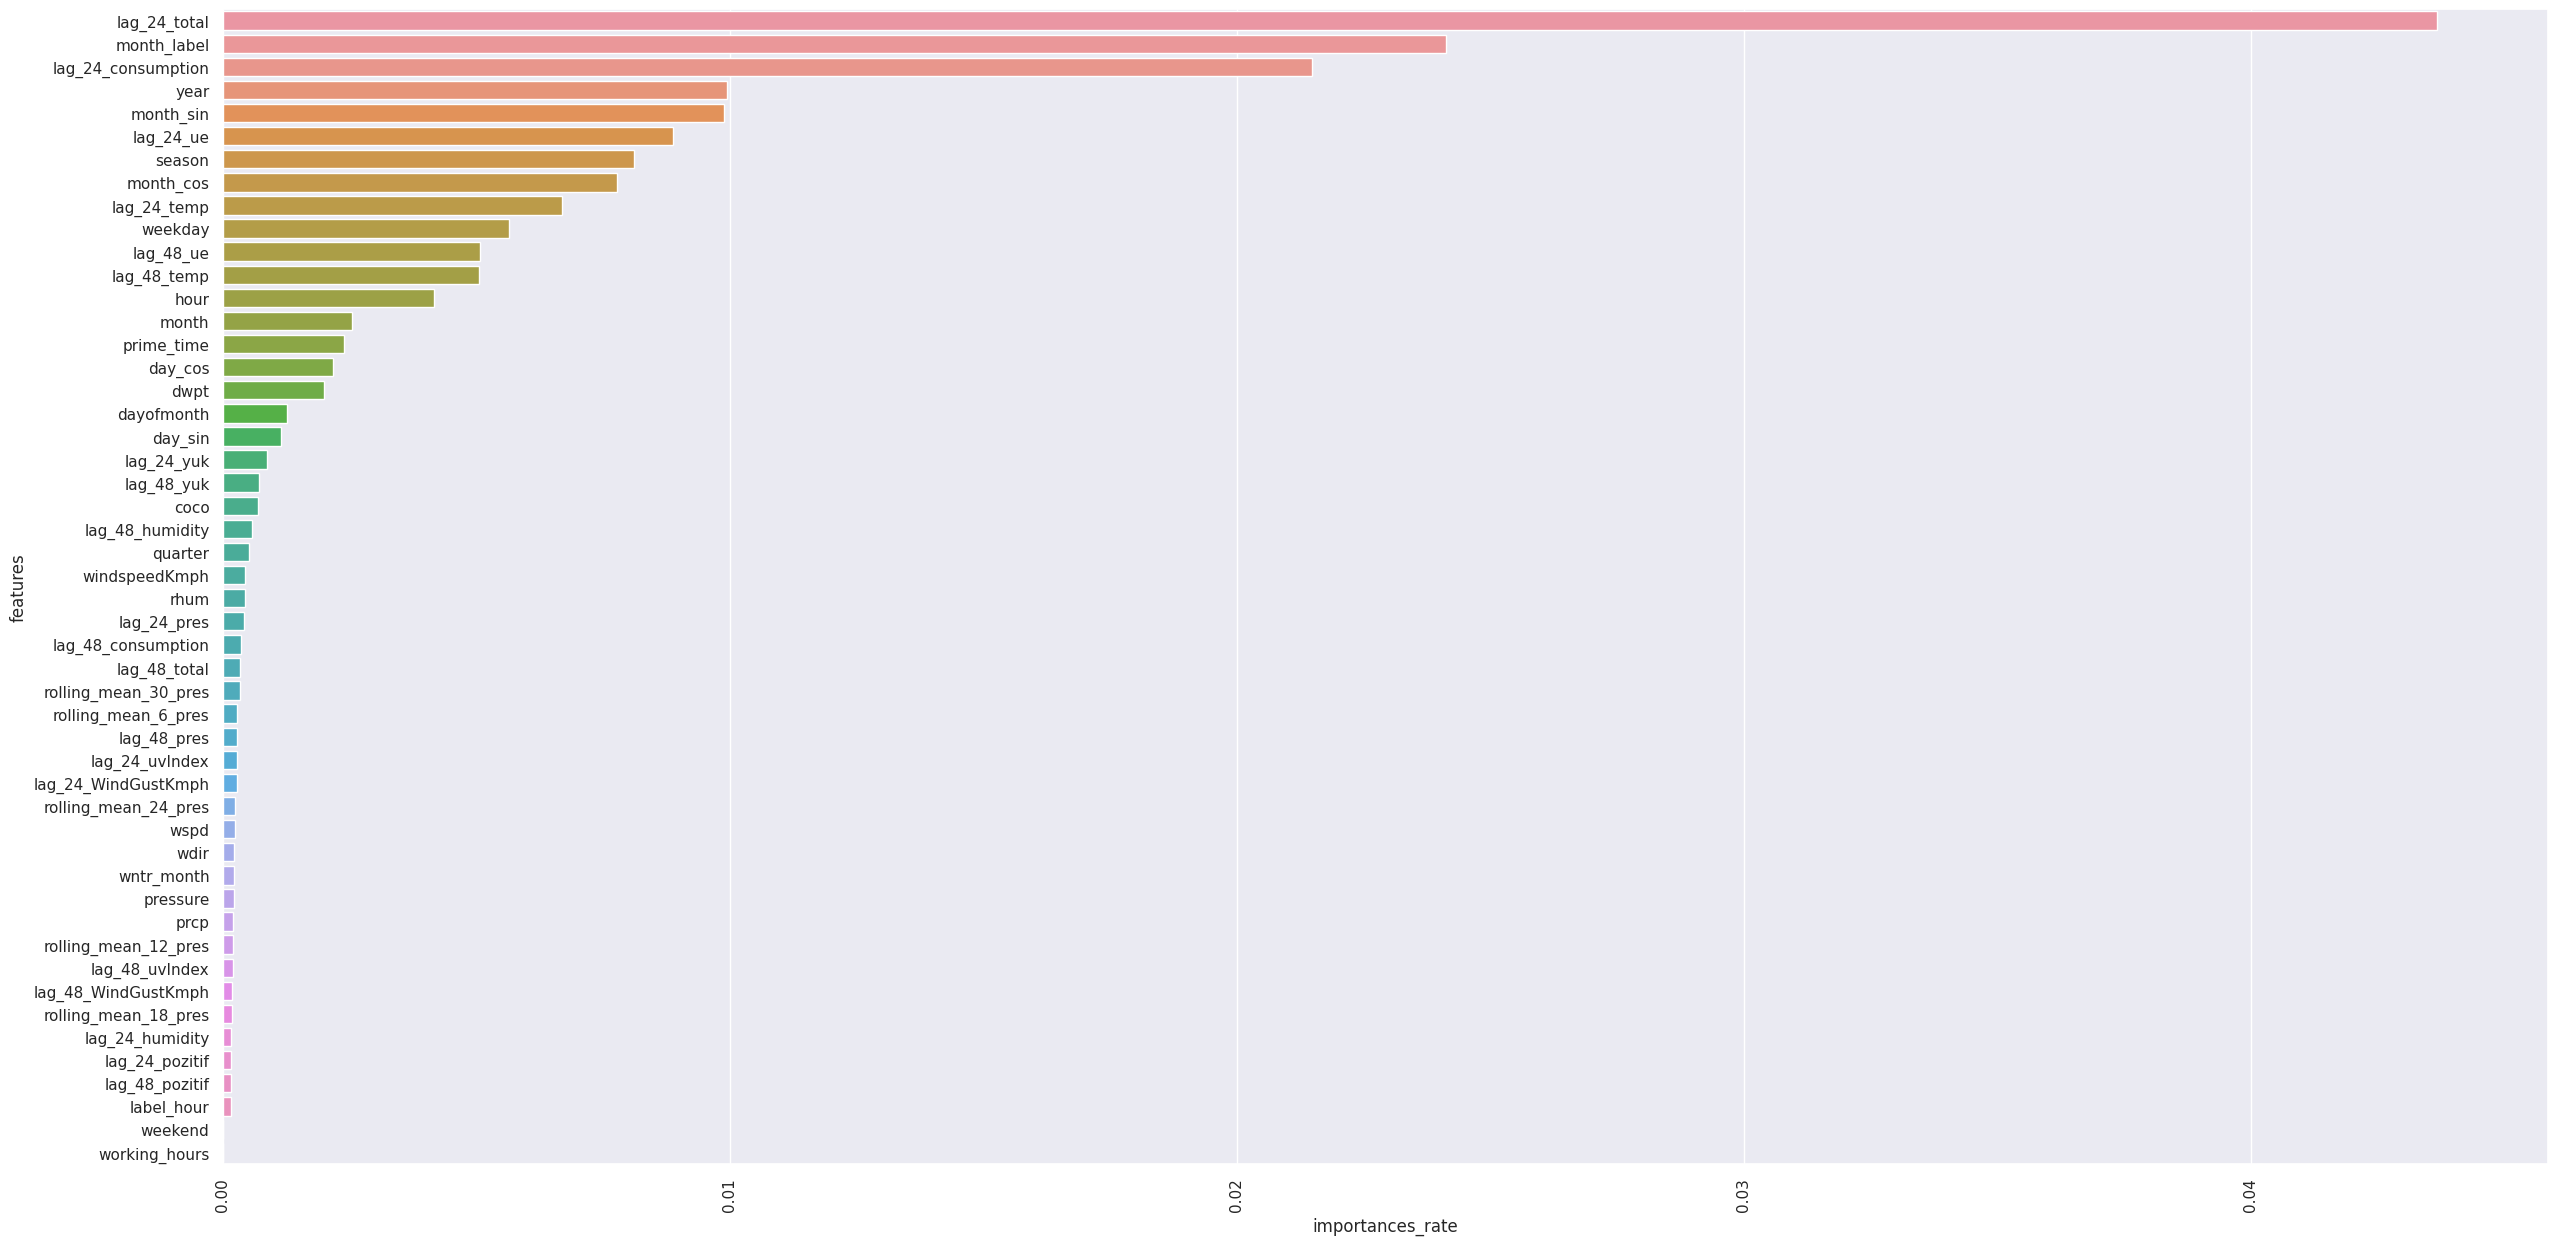

In [26]:
param={
'lambda': 8.437755694055447, 'alpha': 6.838747125274099, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 31,
'n_estimators':2443,
# 'n_tree':2442,
'eval_metric': "mape",
'tree_method':'hist',
'enable_categorical':True,
# 'early_stopping_rounds':500

} 

all_models=[]
for i in [1200, 54,55]:
    param["random_state"] = i
    model = xgb.XGBRegressor(**param)  
    model.fit(train_labeled[:-2200],target[:-2200])
    all_models.append(model)

preds = [model.predict(test_sub)  for model in all_models]
mean_preds = np.mean(preds, axis=0)


print(f'8.ay ortalama tüketim :{train[(train.year==2021) &(train.month==8)].tüketim.mean()}')
print(f'8.ay preds ortalama tüketim:{np.mean(mean_preds)}')
importances=model.feature_importances_
features=test_sub.columns
dum=pd.DataFrame(data={'features':features[:50],'importances_rate':importances[:50]}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(y=dum.features,x=dum.importances_rate,orient='h')
g.set_xticklabels(g.get_xticklabels(), rotation=90);


### Visualization of Validation data and Validation Preds

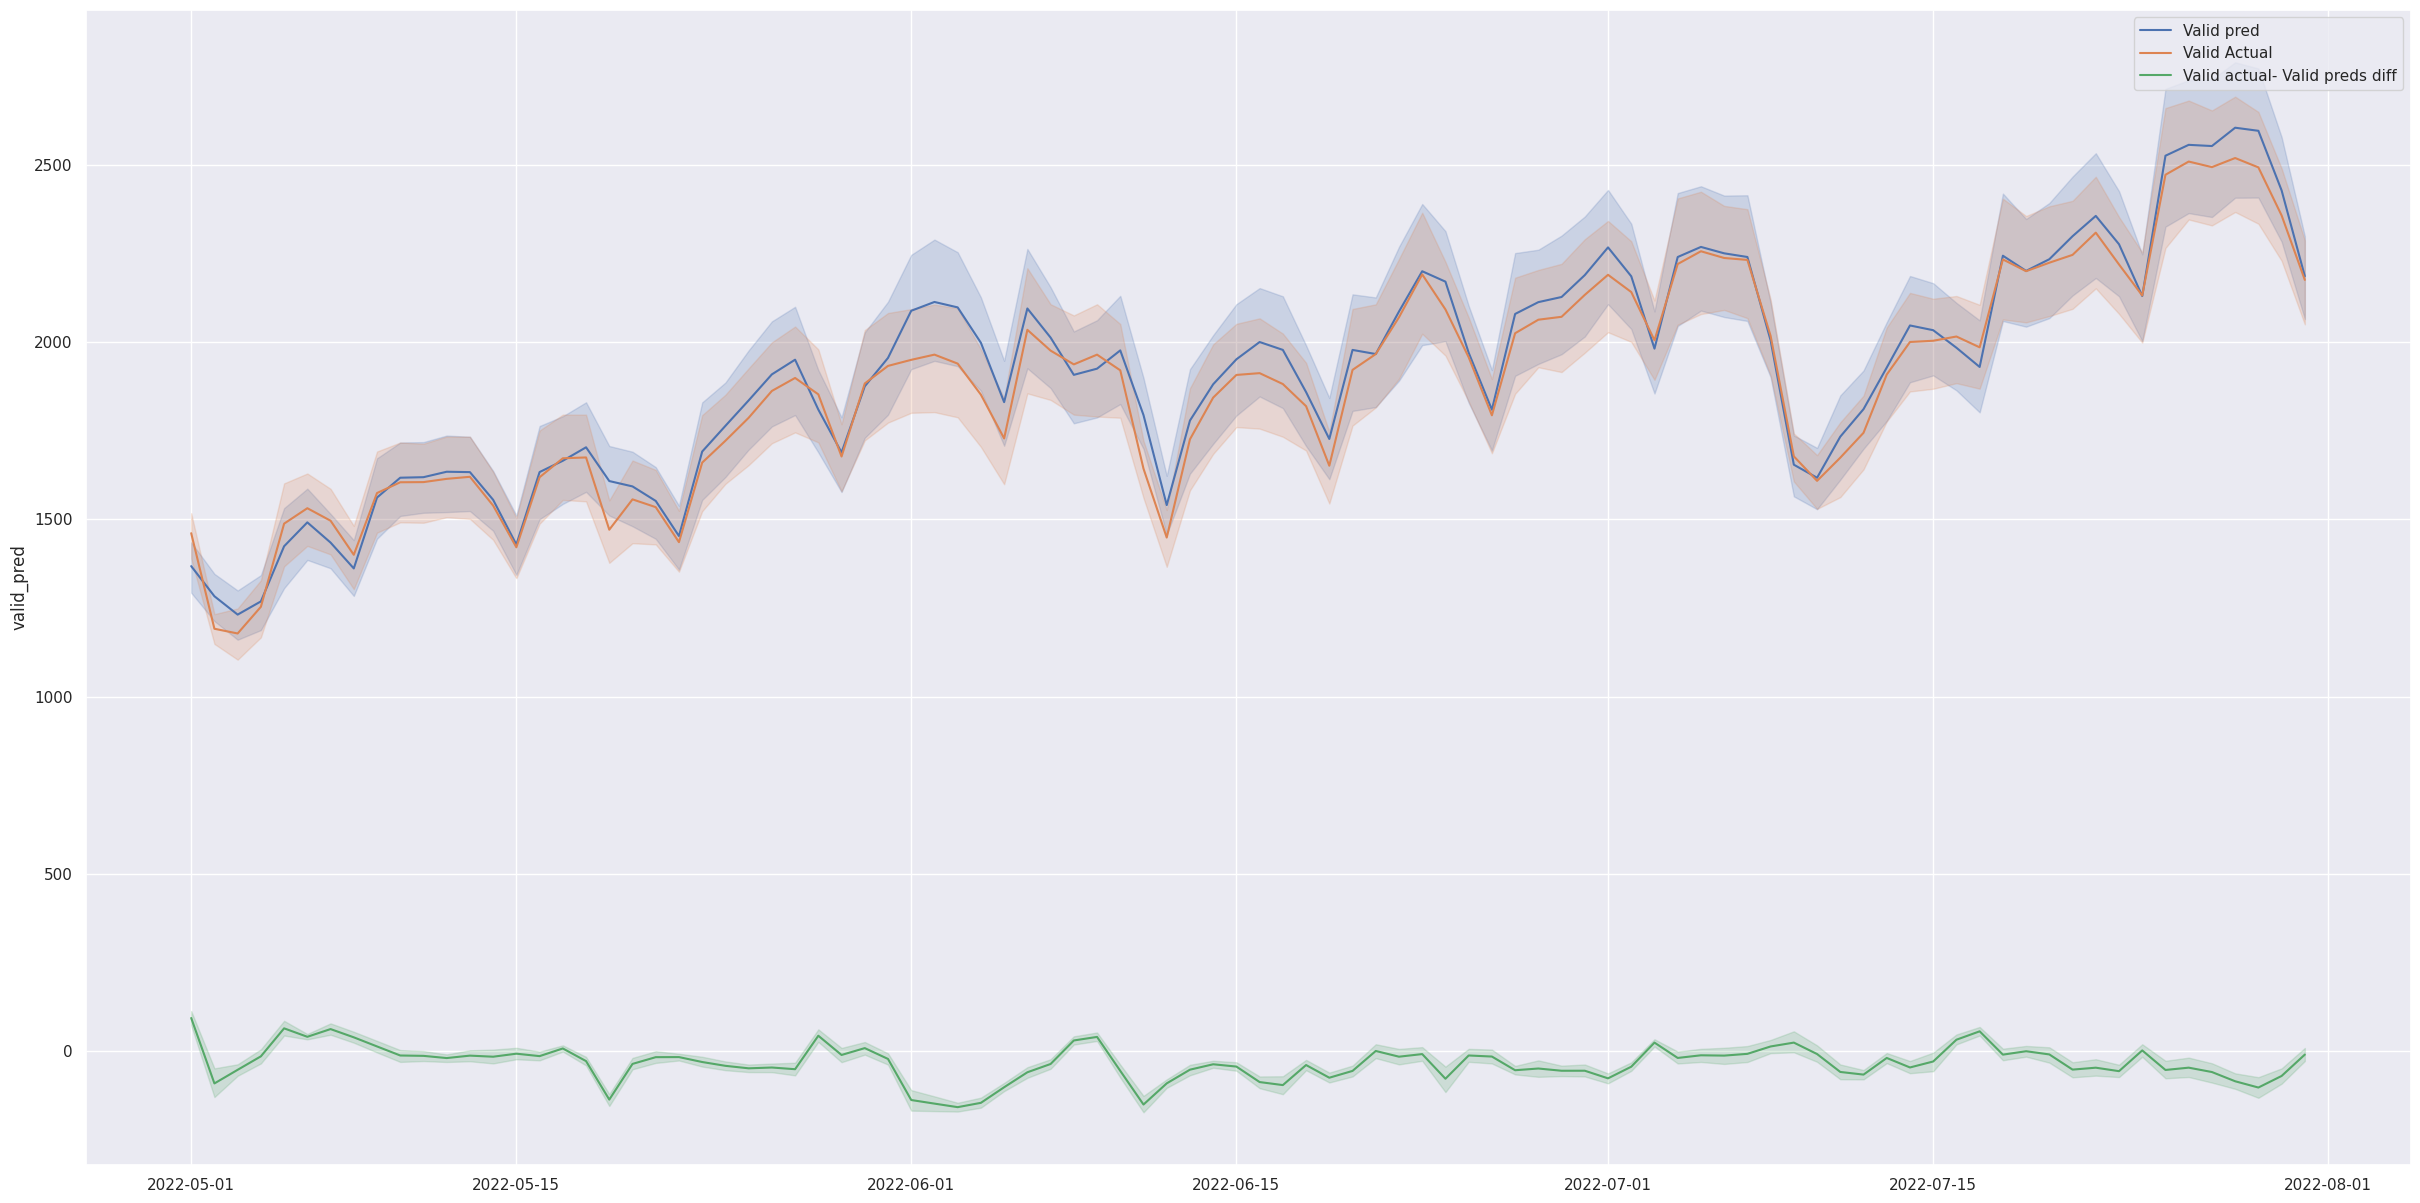

In [27]:
valid=train_labeled.iloc[-2200:] 
valid_target=target.iloc[-2200:]  
index=pd.to_datetime(train[train.tüketim.notnull()].iloc[-2200:].date.values)
valid_pred=model.predict( valid )
valid_pred=pd.Series(valid_pred,index=valid.index)
valid_pred_actual=pd.DataFrame(valid_pred,columns=['valid_pred'])
valid_pred_actual.index=index
valid_pred_actual['tüketim']=valid_target.values
valid_pred_actual['preds_diff']=valid_pred_actual.diff(axis=1).tüketim
sns.lineplot(valid_pred_actual.valid_pred,label='Valid pred');
sns.lineplot(valid_pred_actual.tüketim,label='Valid Actual');
sns.lineplot(valid_pred_actual.preds_diff,label='Valid actual- Valid preds diff');